# 1. 

We seek to show that $FID(P_g, P_D)= FID(P_D, P_G)$. 
Consider
$$|\mu_G-\mu_D|^2 + tr[\Sigma_G + \Sigma_D - 2(\Sigma_G^{1/2} \Sigma_D \sigma_G^{1/2})^{1/2}]$$
$$=|\mu_D-\mu_G|^2 + tr[\Sigma_D + \Sigma_G - 2(\Sigma_G^{1/2} \Sigma_D^{1/2} \Sigma_D^{1/2} \Sigma_G^{1/2})^{1/2}]$$
As the hint suggests, the only issue is the last term in the trace. We consider
$$QQ^T = \Sigma_G^{1/2} \Sigma_D \Sigma_G^{1/2}$$
$$Q^TQ = \Sigma_D^{1/2} \Sigma_G \Sigma_D^{1/2}$$
We see that $QQ^T$ and $Q^TQ$ are SPD and share the same non-zero eigenvalues. Taking matrix square roots preserves eigenvectors and replaces each eigenvalue with its sqrt. Thus, $(QQ^T)^{1/2}$ and $(Q^TQ)^{1/2}$ also have identical spectra and so their traces coincide. 
$$tr((QQ^T)^{1/2})=tr((Q^TQ)^{1/2})$$
Therefore, the two equations are equivalent.

# 2.

In [2]:
import numpy as np

def sqrtm_psd(A, tol=1e-10):
    """
    Returns the symmetric square-root of a symmetric PSD matrix.
    """
    eigvals, eigvecs = np.linalg.eigh(A)
    A = np.clip(eigvals, a_min=0.0, a_max=None)
    A[A < tol * A.max()] = 0.0
    sqrt_A = np.sqrt(A)
    return (eigvecs * sqrt_A) @ eigvecs.T 

def frechet_Distance(features1, features2, eps=1e-6):
    """
    Compute the FID between two collections of feature vectors 
    """
    mu1 = features1.mean(axis=0)
    mu2 = features2.mean(axis=0)
    diff = mu1 - mu2 
    diff_sq = diff @ diff # |mu_1 - mu_2|^2 
    
    sigma_1 = np.cov(features1, rowvar=False) + eps * np.eye(features1.shape[1])
    sigma_2 = np.cov(features2, rowvar=False) + eps * np.eye(features2.shape[1])
    
    covmean_sqrt = sqrtm_psd(sigma_1 @ sigma_2)
    trace_term = np.trace(sigma_1) + np.trace(sigma_2) - 2 * np.trace(covmean_sqrt)
    return float(diff_sq + trace_term)

# 3a)

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

HIDDEN_DIM = 512
LATENT_DIM = 20
lr = 1e-3 
batch_size = 64
eps_clamp = 1e-6

class Encoder(nn.Module):
    def __init__(self, s=784, h=HIDDEN_DIM, d=LATENT_DIM, mode="vae"):
        super().__init__()
        self.mode = mode
        self.fc1 = nn.Linear(s, h)
        if mode == "vae":
            self.fc2 = nn.Linear(h, 2*d)
        else: # auto-encoder
            self.fc2 = nn.Linear(h, d)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        h = self.activation(self.fc1(x))
        out = self.fc2(h)
        if self.mode == "vae":
            mu, logvar = out.chunk(2, dim=1)
            return mu, logvar
        else:
            return out, None

class Decoder(nn.Module):
    def __init__(self, s=784, h=HIDDEN_DIM, d=LATENT_DIM):
        super().__init__()
        self.fc1 = nn.Linear(d, h)
        self.fc2 = nn.Linear(h, s)
        self.activation = nn.ReLU()
        self.output_act = nn.Sigmoid()
        
    def forward(self, x):
        h = self.activation(self.fc1(x))
        logits = self.fc2(h)
        probs = self.output_act(logits)
        return torch.clamp(probs, eps_clamp, 1 - eps_clamp)

class VAE(nn.Module):
    def __init__(self, mode="vae", s=784, h=HIDDEN_DIM, d=LATENT_DIM):
        super().__init__()
        self.mode = mode 
        self.encoder = Encoder(s, h, d, mode)
        self.decoder = Decoder(s, h, d)
    
    def reparam(self, mu, logvar):
        if self.mode == "vae":
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + std * eps 
        else:
            return mu
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparam(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar 

In [78]:
def bce_loss(x, recon):
    return - (x * recon.log() + (1-x) * (1-recon).log())

def vae_loss(x, recon, mu, logvar, mode="vae"):
    recon_loss = bce_loss(x, recon).sum(dim=1).mean()
    
    if mode=="vae":
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
    else:
        kl = torch.tensor(0.0, device=x.device)
    
    return recon_loss + kl, recon_loss, kl

In [79]:
def get_data(batch_size=batch_size):
    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(torch.flatten)  # flatten to 784
    ])
    train = torchvision.datasets.MNIST("./data", train=True,  download=True, transform=tfms)
    test  = torchvision.datasets.MNIST("./data", train=False, download=True, transform=tfms)
    return (
        DataLoader(train, batch_size=batch_size, shuffle=True,  num_workers=2),
        DataLoader(test,  batch_size=batch_size, shuffle=False, num_workers=2),
    )

In [80]:
def train(model, optimizer, loader, device):
    model.train()
    total, recon_total, kl_total = 0, 0, 0
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, recon_loss, kl = vae_loss(x, recon, mu, logvar, model.mode)
        loss.backward()
        optimizer.step()
        
        batch = x.size(0)
        total += loss.item() * batch
        recon_total += recon_loss.item() * batch
        kl_total += kl.item() * batch
    n = len(loader.dataset)
    return total / n, recon_total / n, kl_total / n

def evaluate(model, loader, device):
    model.eval()
    total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss, *_ = vae_loss(x, recon, mu, logvar, model.mode)
            total += loss.item() * x.size(0)
    return total / len(loader.dataset)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# epochs = 200
epochs = 60

train_loader, test_loader = get_data()
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

best_test = float("inf")
ckpt = f"vae_mnist.pth"

for epoch in range(1, epochs + 1):
    train_loss, recon_loss, kl_loss = train(model, optimizer, train_loader, device)
    test_loss = evaluate(model, test_loader, device)
    if test_loss < best_test:
        best_test = test_loss
        torch.save(model.state_dict(), ckpt)
    print(
        f"Epoch {epoch:3d}/{epochs} | "
        f"Train {train_loss:.4f} (recon {recon_loss:.4f}, kl {kl_loss:.4f}) | "
        f"Test {test_loss:.4f} | Best {best_test:.4f}"
    )

print(f"Training complete. Best model saved to {ckpt}")

Epoch   1/60 | Train 143.7081 (recon 125.2408, kl 18.4673) | Test 116.8690 | Best 116.8690
Epoch   2/60 | Train 114.2469 (recon 90.1364, kl 24.1105) | Test 110.7097 | Best 110.7097
Epoch   3/60 | Train 110.2997 (recon 85.4635, kl 24.8362) | Test 108.3459 | Best 108.3459
Epoch   4/60 | Train 108.5119 (recon 83.4384, kl 25.0736) | Test 107.4437 | Best 107.4437
Epoch   5/60 | Train 107.4399 (recon 82.2598, kl 25.1801) | Test 106.8454 | Best 106.8454
Epoch   6/60 | Train 106.7111 (recon 81.4622, kl 25.2489) | Test 105.9504 | Best 105.9504
Epoch   7/60 | Train 106.1673 (recon 80.8494, kl 25.3178) | Test 105.6649 | Best 105.6649
Epoch   8/60 | Train 105.6798 (recon 80.3373, kl 25.3424) | Test 105.1916 | Best 105.1916
Epoch   9/60 | Train 105.2602 (recon 79.9047, kl 25.3555) | Test 104.8658 | Best 104.8658
Epoch  10/60 | Train 105.0104 (recon 79.6300, kl 25.3804) | Test 104.6030 | Best 104.6030
Epoch  11/60 | Train 104.7134 (recon 79.3319, kl 25.3815) | Test 104.3765 | Best 104.3765
Epoch  12

# 3b)

In [74]:
def train_model(mode="vae", h=HIDDEN_DIM, d=LATENT_DIM, epochs=50, lr=lr):
    train_loader, test_loader = get_data()
    model = VAE(mode, h=h, d=d).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    best_val = math.inf
    for ep in range(1, epochs + 1):
        model.train()
        tot, rec, kl = 0, 0, 0
        for x, _ in train_loader:
            x = x.to(device)
            opt.zero_grad()
            recon, mu, logvar = model(x)
            loss, r, k = vae_loss(x, recon, mu, logvar, model.mode)
            loss.backward()
            opt.step()
            b = x.size(0)
            tot += loss.item() * b
            rec += r.item() * b
            kl += k.item() * b
            
        n = len(train_loader.dataset)
        val = evaluate(model, test_loader, device)
        best_val = min(best_val, val)
    n_params = sum(p.numel() for p in model.parameters())
    return model, best_val, n_params

In [75]:
def recon_samples(model, loader, k=16):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:k].to(device)
    with torch.no_grad():
        recon, mu, logvar = model(x)
    imgs = torch.cat([x.view(-1, 1, 28, 28), recon.view(-1, 1, 28, 28)], 0)
    return imgs

In [76]:
from torchvision import utils as vutils
import matplotlib.pyplot as plt
def show_grid(tensor: torch.Tensor, nrow=8):
    grid = vutils.make_grid(tensor, nrow=nrow, pad_value=1.0)
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(nrow, nrow))
    plt.axis('off')
    plt.imshow(npimg, cmap='gray')
    display(plt.gcf())
    plt.close()

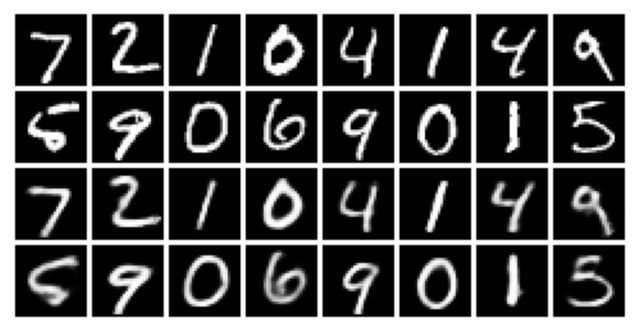

In [25]:
recons = recon_samples(model, test_loader)
show_grid(recons)

# 3c)

In [30]:
def prior_samples(model, n=100):
    z = torch.randn(n, model.decoder.fc1.in_features, device=device)
    with torch.no_grad():
        imgs = model.decoder(z).view(-1, 1, 28, 28)
    return imgs

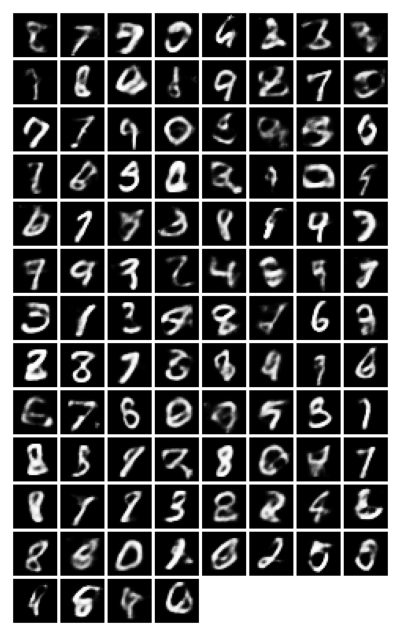

In [31]:
imgs = prior_samples(model)
show_grid(imgs)

# 3d)

In [81]:
class MiniInception(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
    def forward(self, x):
        return self.features(x).view(x.size(0), -1)
    
def get_features(imgs: torch.Tensor) -> np.ndarray:
    _feat_extractor = MiniInception().to(device)
    with torch.no_grad():
        return _feat_extractor(imgs.to(device)).cpu().numpy()

def fid_from_feats(real: np.ndarray, fake: np.ndarray) -> float:
    mu1, mu2 = real.mean(0), fake.mean(0)
    sig1 = np.cov(real, rowvar=False)
    sig2 = np.cov(fake, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm_psd(sig1 @ sig2)
    return float(diff @ diff + np.trace(sig1) + np.trace(sig2) - 2 * np.trace(covmean))

In [82]:
import math
def fid_for_model(model: VAE, n_gen: int = 1000) -> float:
    _, test_loader = get_data()
    real_feats = []
    for x, _ in test_loader:
        imgs = x.view(-1,1,28,28)
        real_feats.append(get_features(imgs))
    real_feats = np.concatenate(real_feats)

    # fake feats
    fake = prior_samples(model, n_gen)
    fake_feats = get_features(fake).astype(np.float64)
    return fid_from_feats(real_feats.astype(np.float64), fake_feats)

In [83]:
def sweep():
    configs = [(h, d) for h in (128,256,512) for d in (10,40)]
    records = []
    for h, d in configs:
        print(f"Training VAE h={h}, d={d} …")
        mdl, val, params = train_model("vae", h, d, epochs=10)
        fid = fid_for_model(mdl)
        records.append((h, d, params, val, fid))
        print(f"→ params {params:} | val {val:.4f} | FID {fid:.2f}\n")
    print(records)
    
    # quick correlation
    vals = np.array([[r[3], r[4]] for r in records])
    corr = np.corrcoef(vals.T)[0,1]
    print("Correlation (val_loss, FID):", corr)

In [85]:
sweep()

Training VAE h=128, d=10 …
→ params 205604 | val 114.6240 | FID 0.32

Training VAE h=128, d=40 …
→ params 217184 | val 109.0160 | FID 0.33

Training VAE h=256, d=10 …
→ params 410404 | val 110.8133 | FID 0.34

Training VAE h=256, d=40 …
→ params 433504 | val 106.0867 | FID 0.27

Training VAE h=512, d=10 …
→ params 820004 | val 108.3339 | FID 0.23

Training VAE h=512, d=40 …
→ params 866144 | val 104.5613 | FID 0.29

[(128, 10, 205604, 114.62401000976563, 0.316856331136071), (128, 40, 217184, 109.01599396972657, 0.32903532889576537), (256, 10, 410404, 110.81326334228515, 0.33732519759920976), (256, 40, 433504, 106.08670256347656, 0.26743073187065636), (512, 10, 820004, 108.33393459472656, 0.2290170855994289), (512, 40, 866144, 104.56132448730469, 0.28656123271711076)]
Correlation (val_loss, FID): 0.48901272219686087


# 3e)

In [91]:
from sklearn.mixture import GaussianMixture
def ae_gmm_fid(h: int = 256, d: int = 10, comps_list: list[int] | None = None,
               n_gen: int = 1_000) -> dict:
    """Train an Auto‑Encoder → fit GMMs in latent space → FID for each k.

    Returns a dict containing:
        {
          'ae_model' : AE model,
          'vae_model': VAE counterpart,
          'val_loss' : AE best validation loss,
          'params'   : #parameters of AE,
          'ae_fids'  :  [(k, fid_k), …],
          'vae_fid'  :  fid_baseline
        }
    """
    comps_list = comps_list or [5, 10, 20]

    ae_model, val_loss, n_params = train_model("ae", h, d)

    tr_loader, _ = get_data()
    zs = []
    ae_model.eval()
    with torch.no_grad():
        for x, _ in tr_loader:
            # Support both .enc and .encoder naming
            encoder = getattr(ae_model, "enc", None) or getattr(ae_model, "encoder")
            z, _ = encoder(x.to(device))
            zs.append(z.cpu().numpy())
    zs = np.concatenate(zs)

    # Pre‑compute real features once for FID speed
    _, test_loader = get_data()
    real_feats = []
    for x, _ in test_loader:
        real_feats.append(get_features(x.view(-1, 1, 28, 28)))
    real_feats = np.concatenate(real_feats).astype(np.float64)

    # Helper to compute FID from decoded tensors
    def fid_from_imgs(img_tensor: torch.Tensor) -> float:
        fake_feats = get_features(img_tensor).astype(np.float64)
        return fid_from_feats(real_feats, fake_feats)

    ae_fids: list[tuple[int, float]] = []
    for k in comps_list:
        gmm = GaussianMixture(k, covariance_type="full", random_state=0).fit(zs)
        z_samp, _ = gmm.sample(n_gen)
        z_samp = torch.tensor(z_samp, dtype=torch.float32, device=device)

        # Locate decoder robustly
        decoder = getattr(ae_model, "dec", None) or getattr(ae_model, "decoder")
        imgs = decoder(z_samp).view(-1, 1, 28, 28)
        fid_k = fid_from_imgs(imgs)
        ae_fids.append((k, fid_k))

    vae_model, _, _ = train_model("vae", h, d)
    vae_fid = fid_for_model(vae_model)

    return {
        "ae_model": ae_model,
        "vae_model": vae_model,
        "val_loss": val_loss,
        "params": n_params,
        "ae_fids": ae_fids,
        "vae_fid": vae_fid,
    }

def compare_ae_gmm_vs_vae(show_n: int = 64):
    """Run the AE‑GMM experiment and display sample grids + printed FIDs."""
    summary = ae_gmm_fid()

    # Pretty print
    print(f"AE (h=256,d=10)  | params: {summary['params']:,} | val_loss {summary['val_loss']:.4f}")
    for k, f in summary['ae_fids']:
        print(f"  GMM-{k:>2d} components → FID {f:.2f}")
    print(f"VAE baseline         → FID {summary['vae_fid']:.2f}\n")

    # --- Show samples -------------------------------------------------------------
    cols = len(summary["ae_fids"]) + 1
    plt.figure(figsize=(cols * 2.5, 2.5))

    # helper to draw a subplot
    def _subplot(idx: int, imgs: torch.Tensor, title: str):
        plt.subplot(1, cols, idx); plt.axis("off");
        grid = vutils.make_grid(imgs[:show_n], nrow=int(math.sqrt(show_n)), pad_value=1.0)
        plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
        plt.title(title)

    # AE‑GMM grids
    for i, (k, _) in enumerate(summary["ae_fids"], 1):
        gmm = GaussianMixture(k, covariance_type="full", random_state=0)  # re‑fit quickly
        gmm.fit(np.concatenate([z.cpu().numpy() for z in summary['ae_model'].enc(torch.randn(10, 784, device=device)).chunk(1, 0)]))
        z_samp, _ = gmm.sample(show_n)
        decoder = getattr(summary['ae_model'], "dec", None) or summary['ae_model'].decoder
        imgs = decoder(torch.tensor(z_samp, dtype=torch.float32, device=device)).view(-1,1,28,28)
        _subplot(i, imgs, f"AE‑GMM {k}")

    # VAE prior grid
    vae_imgs = prior_samples(summary["vae_model"], show_n)
    _subplot(cols, vae_imgs, "VAE prior")

    plt.show();
    return summary

In [92]:
summary = compare_ae_gmm_vs_vae(show_n=64)

AE (h=256,d=10)  | params: 407,834 | val_loss 80.9863
  GMM- 5 components → FID 0.37
  GMM-10 components → FID 0.26
  GMM-20 components → FID 0.32
VAE baseline         → FID 0.25



AttributeError: 'VAE' object has no attribute 'enc'

<Figure size 1000x250 with 0 Axes>